In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer

In order to utilize Tensorflow etc., I had to switch to Kaggle, which offers free GPU.

In [3]:
df = pd.read_csv("/kaggle/input/emails/emails30MB.csv", header = None)
df.columns = ["file" , "message" ]

In the following code, I tried to receive meaningfull, folder related information from the messages. After reading the csv, this function will perform some text preprocessing in order to extract knowledge. Here, subject, x_folder and their sub_folder is extracted. At the end, I tried to extract the body-text, assuming that text instances that don't include @ (mail adresses) , : (for categories like date:, from: etc.) should contain the text, which its validity is questionable.

In [4]:
def get_relevant_information(df):
    msg = df.message 
    subjects = []
    for m in msg :  
        t = m.split('\n')
        for t in t : 
            t = t.lower()
            if 'subject:' in t :
                subjects.append(t[8:])
                break
            
    df['subjects'] = subjects
    folders = []
    sub_folders = []
    for m in msg :  
        t = m.split('\n')
        for t in t : 
            t = t.lower()
            if 'x-folder:' in t :
                folders.append(t[9:])
                sub_folders.append(t.split('\\')[-1]) 
                break
    df['folders'] = folders
    df['sub_folders'] = sub_folders
    body = []
    for m in msg :  
        b = ""
        t = m.split('\n')
        for t in t : 
            t = t.lower()
            if '@' not in t and ':' not in t and 'forwarded' not in t and '\t' not in t:
                b += t
                
        body.append(b)
    df['body'] = body
    return df

In [5]:
# transforming the dataframe
df = get_relevant_information(df)

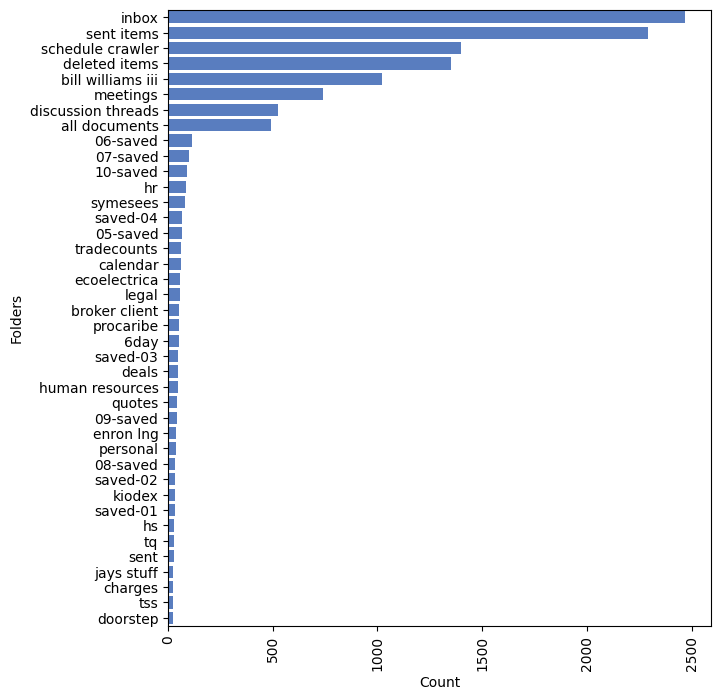

In [6]:
# dataframe containing counts of every word in the emails dataframe
email_count = df["sub_folders"].value_counts()
indices = email_count.index
count = pd.DataFrame()
count['X-Folder'] = email_count
count["Folder Names"] = indices


def barplot(df, X, Y, figsize, color, orient, ylabel, xlabel, font_scale, rotation):
    f, ax = plt.subplots(figsize=figsize)
    sns.set_color_codes("muted")
    sns.barplot(x = X, y = Y, data = df, color = color, orient = orient)
    ax.set(ylabel = ylabel, xlabel = xlabel)
    sns.set(font_scale = font_scale)
    plt.xticks(rotation = rotation) 
    plt.show()
    
barplot(df = count[:40], X = "X-Folder", Y = "Folder Names", figsize = (7, 8), color = 'b', orient = 'h', ylabel = "Folders", xlabel = "Count", font_scale = 1.2, rotation = 90)

After seeing that some sub folders are consistently more frequently used than others, I have decided to filter my data to the following, frequent occuring folders. Unbalanced categories are a common problem.

**Bias Towards Majority Class:** Machine learning algorithms tend to perform better on the majority class, leading to poor predictive performance on the minority class.
**Misleading Accuracy:** Overall accuracy can be misleading, as high accuracy might simply reflect the model’s performance on the majority class.
**Poor Recall for Minority Class:** The model might miss many instances of the minority class, which can be critical in applications like fraud detection or disease diagnosis.

In order to avoid such issues, undersampling will be performed.

In [44]:
df = df[df['sub_folders'].isin(['inbox','sent items','schedule crawler','deleted items','meetings','discussion threads','all documents'])]

In [45]:
# Labeling each category with numbers
df['category_id'] = df['sub_folders'].factorize()[0]

In order to train text data, they need to be converted into numbers. F-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used in natural language processing and information retrieval to evaluate the importance of a word in a document relative to a collection of documents. It combines two key metrics: term frequency (TF) and inverse document frequency (IDF).

In [9]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',
                        encoding='latin-1', ngram_range=(1, 2), stop_words='english')

# I have joined the meaningful texts together, in order to increase informability.
#Could be questionable if joining like that is valid
classifier_text = df.body + df.subjects

#transforming into tfidf
features = tfidf.fit_transform(classifier_text).toarray()
labels = df.category_id
features.shape

(9262, 29204)

In [17]:
#splitting data for training 
#sample, naive bayes model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


X_train, X_test, y_train, y_test = train_test_split(df['body']+df['subjects'], df['sub_folders'],
                                                    random_state = 0, test_size = 0.10)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.fit_transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)

#fitting the model
clf = MultinomialNB().fit(X_train_tfidf, y_train)

To have quick look to our model, I will try to predict one sample

In [11]:
X_test[2754],y_test[2574]

('doug,another example of the "data integrity" issues bill and i referred to previously.  before setting up either of the crosstimbers companies, we would expect and recommend a thorough review of the booking of their existing trades, from tagg deal entry through sitara/cpr and unify.regards,debbieplease consider cross timbers oil company for cl applicationalso, for our information, both cross timbers oil company and cross timbers energy services have transactions booked on our systems.cross timbers oil companyprior month\'s gas (early pay)             $6,505,113.57  current month\'s gas (pre-pay)         $14,506,601.59  contracted future gas delivery       $93,851,244.49  cross timbers energy servicesprior month\'s gas (early pay)              $636,838.74  current month\'s gas (pre-pay)            $228,130.60  contracted future gas delivery                        -0-are the deals with ctes booked incorrectly?    the numbers for prior month are coming from unify, and the current month 

In [12]:
clf.predict(count_vect.transform(['doug,another example of the "data integrity" issues bill and i referred to previously.  before setting up either of the crosstimbers companies, we would expect and recommend a thorough review of the booking of their existing trades, from tagg deal entry through sitara/cpr and unify.regards,debbieplease consider cross timbers oil company for cl applicationalso, for our information, both cross timbers oil company and cross timbers energy services have transactions booked on our systems.cross timbers oil companyprior month\'s gas (early pay)             $6,505,113.57  current month\'s gas (pre-pay)         $14,506,601.59  contracted future gas delivery       $93,851,244.49  cross timbers energy servicesprior month\'s gas (early pay)              $636,838.74  current month\'s gas (pre-pay)            $228,130.60  contracted future gas delivery                        -0-are the deals with ctes booked incorrectly?    the numbers for prior month are coming from unify, and the current month are coming from cprdougplease direct approval requests through jay  williams and copy debbie and i.  southwest royalties should be rejected due to credit quality and cross timbers energy services, inc. should not be approved but we would be willing to consider cross timbers oil company.  all purchases should be directly with cross timbers oil company with no transactions with energy services.billhello,please review the attached spreadsheet for the outstanding credit approval requests for the financial management module of commoditylogic.1/08/01   southwest royalties, inc. (cpid- 2912)1/16/01  cross timbers energy services, inc. (cpid - 29765)please reply with the credit status as soon as possible, in order to complete the application process.thank you,andreaproduct control group - commoditylogicx54420 re: credit approval request - commoditylogic']))

array(['inbox'], dtype='<U18')

Well the first prediction has failed... Let's have a extensive look over several models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

C:\Users\Korhan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Increase the number of iterations (max_iter) or scale the data as shown in:

    https://scikit-learn.org/stable/modules/preprocessing.html

Please also refer to the documentation for alternative solver options:

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

  n_iter_i = _check_optimize_result(

C:\Users\Korhan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Increase the number of iterations (max_iter) or scale the data as shown in:

    https://scikit-learn.org/stable/modules/preprocessing.html

Please also refer to the documentation for alternative solver options:

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

This should be the outcome

![image info](results.png)

The accuracy of the models is questionable, only one performance metrics should not be used. The labels I provided such as deleted items, Inbox items might not be the most relevant terms with the given text. 

Here I tried to provide results as fast as possible.


Transformer Models

In [59]:
#Choosing the two most common categories for binary classification (for simplicity)
df = df[df['sub_folders'].isin(['inbox','sent items',])]
df['category_id'] = df['sub_folders'].factorize()[0]
df['text'] = df['body']+df['subjects']

In [62]:
#splitting dfs into test and train
train_df, test_df = train_test_split(df, test_size=0.2)
train_df = train_df[['text', 'category_id']]
test_df = test_df[['text', 'category_id']]

In [63]:
train_texts = train_df['text']#.values
train_labels = train_df['category_id']#.values

test_texts = test_df['text']#.values
test_labels = test_df['category_id']#.values

In [54]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

In [55]:
model_name = 'distilbert-base-uncased'
device_name = 'cuda'

# This is the maximum number of tokens in any document; the rest will be truncated.
max_length = 512

# This is the name of the directory where we'll save our model. You can name it whatever you want.
cached_model_directory_name = 'output_hf'

In [56]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [64]:
from datasets import Dataset

train_df = Dataset.from_pandas(train_df)
test_df = Dataset.from_pandas(test_df)

def tokenize_function(examples):
  return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_train_df = train_df.map(tokenize_function, batched=True)
tokenized_test_df = test_df.map(tokenize_function, batched=True)

Map:   0%|          | 0/3808 [00:00<?, ? examples/s]

Map:   0%|          | 0/952 [00:00<?, ? examples/s]

Fine Tuning

In [65]:
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating a HuggingFace Trainer object using the TrainingArguments object  created above.  Sending compute_metrics function to the Trainer object, along with test and train datasets

In [66]:
training_args = TrainingArguments(
    num_train_epochs=3,              # total number of training epochs
    output_dir='./results',          # output directory
    report_to='none'
)

In [67]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [68]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_train_df,         # training dataset
    compute_metrics=compute_metrics      # our custom evaluation function
)

In [69]:
trainer.train()

OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 85, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/distilbert/modeling_distilbert.py", line 991, in forward
    distilbert_output = self.distilbert(
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/distilbert/modeling_distilbert.py", line 811, in forward
    return self.transformer(
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/distilbert/modeling_distilbert.py", line 572, in forward
    layer_outputs = layer_module(
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/distilbert/modeling_distilbert.py", line 498, in forward
    sa_output = self.attention(
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/distilbert/modeling_distilbert.py", line 230, in forward
    scores = scores.masked_fill(
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 63.06 MiB is free. Process 2413 has 14.68 GiB memory in use. Of the allocated memory 859.72 MiB is allocated by PyTorch, and 28.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


I have encountered a GPU issue which I never had with Kaggle before... I lost a lot of time looking for a solution, which was a waste of time.  
With this markdown cell, I am finishing this notebook, unable to perform deep learning techniques, hoping that the technical issue will be taken into consideration. 

What I tried to do is use a pretrained transformer model and fine tune it in order to classify my datasets according to subfolders.
